In [1]:
# Generate n images
# Get CLIP embeddings and PAE targets for each for some categories
# Compare with Text Embeddings

import torch
import numpy as np
import copy
import pickle
import time

from clip_utils.clip_loss import CLIPLoss
from training_utils.training_utils import get_lr
from get3d_utils import constructGenerator, eval_get3d_single

In [2]:
def preprocess_rgb_grid(array):
    gh = 1

    lo, hi = -1, 1
    img = array
    img = (img - lo) * (255 / (hi - lo))
    img.clip(0, 255)

    _N, C, H, W = img.shape
    gw = _N // gh
    img = img.reshape([gh, gw, C, H, W])
    img = img.transpose(0, 3, 1, 4, 2)
    img = img.reshape([gh * H, gw * W, C])
    return img.astype(np.uint8)

In [3]:
with open('test.pickle', 'rb') as f:
    generator_args = pickle.load(f)

G_ema = constructGenerator(**generator_args)

constructing
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.
==> resume from pretrained path pretrained_model/shapenet_car.pt


In [4]:
torch.manual_seed(0)

imgs = []
geo_latents = []
tex_latents = []

with torch.no_grad():
    g_ema = copy.deepcopy(G_ema).eval()
    for i in range(100):
        z = torch.randn([1, 512], device='cuda')  # random code for geometry
        tex_z = torch.randn([1, 512], device='cuda')  # random code for texture
        c = torch.ones(1, device='cuda')
        output = eval_get3d_single(g_ema, z, tex_z, c)
        geo_latents.append(z)
        tex_latents.append(tex_z)
        imgs.append(output)

/home/windows-ssh/git/GET3D/training/networks_get3d.py:467: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  camera_theta = torch.range(0, n_camera - 1, device=self.device).unsqueeze(dim=-1) / n_camera * math.pi * 2.0
/home/windows-ssh/git/GET3D/training/networks_get3d.py:467: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  camera_theta = torch.range(0, n_camera - 1, device=self.device).unsqueeze(dim=-1) / n_camera * math.pi * 2.0


In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_pca(images, text_prompt, power, method='PCA+10'):
    with torch.no_grad():
        loss_clip = CLIPLoss(text_prompt=text_prompt)
        
        text_embedding = loss_clip.get_embedding_target(None).cpu().numpy()
        clip_space_embeddings_imgs = [loss_clip.get_embedding_image(img[0]).cpu().numpy() for img in imgs]
        
        clip_pae_embeddings_imgs = []
        for img in images:
            loss_clip_pae = CLIPLoss(text_prompt=text_prompt, target_type='PAE', clip_pae_args={'original_image': img, 'power': power, 'method': method})
            clip_pae_embeddings_imgs.append(loss_clip_pae.get_embedding_target(img).cpu().numpy())
    
        all_embeddings = np.array([text_embedding] + clip_space_embeddings_imgs + clip_pae_embeddings_imgs)
        all_embeddings = np.squeeze(all_embeddings, axis=1)
    
        pca = PCA(n_components=2)
        pca.fit(all_embeddings)
        
        text_embedding_transformed = pca.transform(text_embedding)
        clip_space_embeddings_imgs = pca.transform(np.squeeze(np.array(clip_space_embeddings_imgs), axis=1))
        clip_pae_embeddings_imgs = pca.transform(np.squeeze(np.array(clip_pae_embeddings_imgs), axis=1))
    
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.scatter(text_embedding_transformed[:,0], text_embedding_transformed[:,1], label='Text Embedding')
        ax.scatter(clip_space_embeddings_imgs[:,0], clip_space_embeddings_imgs[:,1], label='CLIP Image Embeddings')
        ax.scatter(clip_pae_embeddings_imgs[:,0], clip_pae_embeddings_imgs[:,1], label='CLIP-PAE Image Embeddings')
        
        plt.legend()
        plt.show()

# PCA

## PAE + Augmentation Power 1

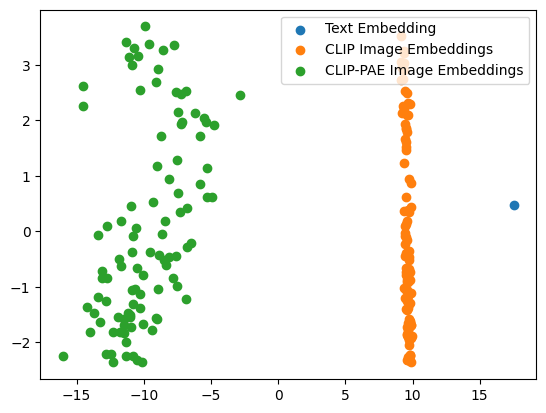

In [16]:
plot_pca(imgs, 'Sports Car', 1, 'PCA+10') # PCA+(Number of Components)

# PAE Augmentation Power 5

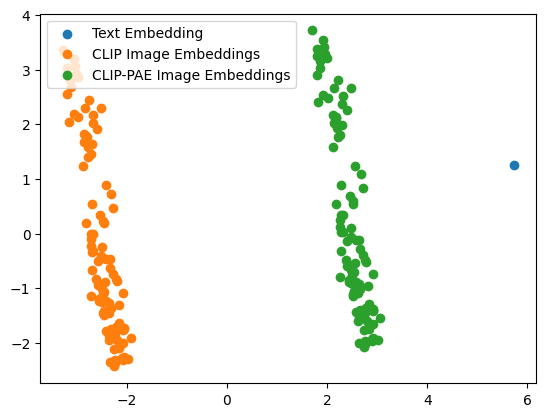

In [18]:
plot_pca(imgs, 'Sports Car', 5, 'PCA10')

# Gram-Schmidt

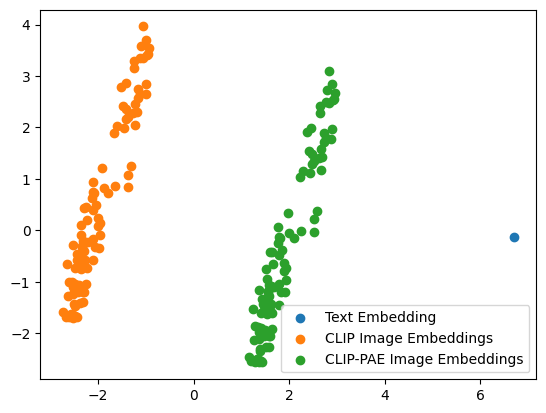

In [23]:
plot_pca(imgs, 'SUV', 4, 'GS')